In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches



In [23]:
def load_trend_data(variable, model, experiment, period):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend_{period}_stats.nc"
    trend_data = xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

    w = np.sqrt(np.cos(np.radians(trend_data['lat'])))
    w2d, _ = xr.broadcast(w, trend_data)
    trend_data = trend_data * w2d

    return trend_data

def load_proj_or_resid_data(variable, result, mode, model, experiment, period):
    #loads in the projected or residual data
    #mode is NAO/EA, result is proj/res
    filepath = f"{base_dir}/projection_indicies/NAtlantic_forced_trends/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_{mode}_{result}_{period}_EOF2.nc"
    #if experiment == 'hist-aer' and mode == 'EA' and result == 'projection':
    #    return -(xr.open_dataset(filepath))
    return xr.open_dataset(filepath)

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)

# Define the model name and path template
model = ['HadGEM3-GC31-LL']
base_dir = '/gws/nopw/j04/extant/users/slbennie'

period = '1850-2015'
period_title = '1850-2014'

# List of forcing experiments
experiments = ['historical']#, 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']


for m in model:
    # Load trend data
    trend_data = {experiment: load_trend_data('psl', m, experiment, period) for experiment in experiments}
    print(trend_data)

    # Load NAO projection and residual
    proj_data = {experiment: load_proj_or_resid_data('psl', 'projection', 'NAO', m, experiment, period) for experiment in experiments}
    residual_data = {experiment: load_proj_or_resid_data('psl', 'residual', 'NAO', m, experiment, period) for experiment in experiments}
    
    # Load EA projection and residual
    proj_data_EA = {experiment: load_proj_or_resid_data('psl', 'projection', 'EA', m, experiment, period) for experiment in experiments}
    residual_data_EA = {experiment: load_proj_or_resid_data('psl', 'residual', 'EA', m, experiment, period) for experiment in experiments}

#residual_data_EA['hist-aer']['residual_EA_djf'] = residual_data_EA['hist-aer']['residual_EA_djf'] - (2*proj_data_EA['hist-aer']['projection_EA_djf'])

# Define experiments to include in the sum (excluding 'historical')
experiments_to_sum = ['historical']#[e for e in experiments if e != 'historical']

# Helper function to sum datasets
def sum_datasets(dataset_dict, variable_name):
    datasets = [dataset_dict[e][variable_name] for e in experiments_to_sum]
    summed_data = sum(datasets)
    return summed_data

#creating a 'sum' entry - basically summing all the single forcings for each row.
# Add 'sum' entry to each data dictionary
trend_data['sum'] = trend_data[experiments_to_sum[0]].copy(deep=True)
trend_data['sum']['slope'] = sum_datasets(trend_data, 'slope')

proj_data['sum'] = proj_data[experiments_to_sum[0]].copy(deep=True)
proj_data['sum']['projection_NAO_djf'] = sum_datasets(proj_data, 'projection_NAO_djf')

residual_data['sum'] = residual_data[experiments_to_sum[0]].copy(deep=True)
residual_data['sum']['residual_NAO_djf'] = sum_datasets(residual_data, 'residual_NAO_djf')

proj_data_EA['sum'] = proj_data_EA[experiments_to_sum[0]].copy(deep=True)
proj_data_EA['sum']['projection_EA_djf'] = sum_datasets(proj_data_EA, 'projection_EA_djf')

residual_data_EA['sum'] = residual_data_EA[experiments_to_sum[0]].copy(deep=True)
residual_data_EA['sum']['residual_EA_djf'] = sum_datasets(residual_data_EA, 'residual_EA_djf')

# Also add 'sum' to experiments list if needed later
experiments.append('sum')

#finding the min and max for each dataset to set a colour scheme for all of the plots
min_trend, max_trend = get_min_max(trend_data, 'slope')
min_proj, max_proj = get_min_max(proj_data, 'projection_NAO_djf')
min_resid, max_resid = get_min_max(residual_data, 'residual_NAO_djf')
min_proj_EA, max_proj_EA = get_min_max(proj_data_EA, 'projection_EA_djf')
min_resid_EA, max_resid_EA = get_min_max(residual_data_EA, 'residual_EA_djf')

# Overall min/max
min_all = min(min_trend, min_proj, min_resid, min_proj_EA, min_resid_EA)
max_all = max(max_trend, max_proj, max_resid, max_proj_EA, max_resid_EA)

# Color normalization
norm_all = mcolors.TwoSlopeNorm(vmin=min_all, vcenter=0, vmax=max_all)

print(min_all, max_all)

#FINDING R^2

r2_scores = {}

for e in experiments:
    # Flatten trend data
    trend_array = trend_data[e]['slope'].values.flatten()
    trend_total_variance = np.sum(trend_array**2)

    # Flatten projections
    proj_NAO = proj_data[e]['projection_NAO_djf'].values.flatten()
    proj_EA  = proj_data_EA[e]['projection_EA_djf'].values.flatten()
    res = residual_data_EA[e]['residual_EA_djf'].values.flatten()
    #var_res = np.sum((residual_data_EA[e]['residual_EA_djf'].values.flatten()**2))

   # assert np.isclose(proj_NAO + proj_EA + var_res, trend_total_variance)

    # Compute variance explained
    r2_NAO = np.sum(proj_NAO**2) / trend_total_variance
    r2_EA  = np.sum(proj_EA**2)  / trend_total_variance
    r2_res = np.sum(res**2) / trend_total_variance

    # Store in nested dict
    r2_scores[e] = {
        'NAO': r2_NAO,
        'EA': r2_EA,
        'res': r2_res
    }

# Example: print r² for all
for exp, scores in r2_scores.items():
    print(f"{exp}: r²_NAO = {scores['NAO']:.4f}, r²_EA = {scores['EA']:.4f}, r²_res = {scores['res']:.4f}")

print(min_all,max_all)

{'historical': <xarray.Dataset> Size: 54kB
Dimensions:         (lat: 25, lon: 53)
Coordinates:
  * lat             (lat) float64 200B 20.0 22.5 25.0 27.5 ... 75.0 77.5 80.0
  * lon             (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
Data variables:
    slope           (lat, lon) float64 11kB 0.2345 0.2103 ... 0.09927 0.1171
    intercept       (lat, lon) float64 11kB 1.624e+05 1.625e+05 ... 6.986e+04
    p_value         (lat, lon) float64 11kB 1.455e-08 8.003e-08 ... 0.1815 0.135
    slope_CI_lower  (lat, lon) float64 11kB 0.1581 0.1377 ... -0.0756 -0.06108
    slope_CI_upper  (lat, lon) float64 11kB 0.3109 0.283 ... 0.2741 0.2952}
<xarray.DataArray 'slope' ()> Size: 8B
array(-0.88937393) <xarray.DataArray 'slope' ()> Size: 8B
array(0.70376764)
historical: r²_NAO = 0.6019, r²_EA = 0.1359, r²_res = 0.2623
sum: r²_NAO = 0.6019, r²_EA = 0.1359, r²_res = 0.2623
<xarray.DataArray 'slope' ()> Size: 8B
array(-0.88937393) <xarray.DataArray 'slope' ()> Size: 8B
array(0.70376764)

In [28]:
def load_trend_data(variable, model, experiment, period):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend_{period}_stats.nc"
    trend_data = xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

    w = np.sqrt(np.cos(np.radians(trend_data['lat'])))
    w2d, _ = xr.broadcast(w, trend_data)
    trend_data = trend_data * w2d

    return trend_data

def load_proj_or_resid_data(variable, result, mode, model, experiment, period):
    #loads in the projected or residual data
    #mode is NAO/EA, result is proj/res
    filepath = f"{base_dir}/projection_indicies/NAtlantic_forced_trends/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_{mode}_{result}_{period}_EOF.nc"
    #if experiment == 'hist-aer' and mode == 'EA' and result == 'projection':
    #    return -(xr.open_dataset(filepath))
    return xr.open_dataset(filepath)

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)

def sum_datasets(dataset_dict, variable_name):
    datasets = [dataset_dict[e][variable_name] for e in dataset_dict if e != 'sum']
    summed_data = sum(datasets)
    return summed_data

# Define the model name and path template
model = ['HadGEM3-GC31-LL']
base_dir = '/gws/nopw/j04/extant/users/slbennie'

period = '1850-2015'
period_title = '1850-2014'

# List of forcing experiments
experiments = ['historical']#, 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']# Initialize r2_scores dictionary
# Initialize dictionaries
trend_data, proj_data, proj_data_EA = {}, {}, {}
residual_data, residual_data_EA = {}, {}

for m in model:
    for e in experiments:
        try:
            # Try loading trend data
            trend_data[e] = load_trend_data('psl', m, e, period)
            proj_data[e] = load_proj_or_resid_data('psl', 'projection', 'NAO', m, e, period)
            proj_data_EA[e] = load_proj_or_resid_data('psl', 'projection', 'EA', m, e, period)
            residual_data[e] = load_proj_or_resid_data('psl', 'residual', 'NAO', m, e, period)
            residual_data_EA[e] = load_proj_or_resid_data('psl', 'residual', 'EA', m, e, period)
    
        except FileNotFoundError as fnf:
            print(f"Skipping {e} due to missing file: {fnf}")
        except KeyError as ke:
            print(f"Skipping {e} due to missing variable/key: {ke}")

# Now you can safely compute R² only for successfully loaded datasets
r2_scores = {}

for e in experiments:
    if e not in trend_data:
        # Skip experiments that failed to load
        r2_scores[e] = {'NAO': np.nan, 'EA': np.nan, 'res': np.nan}
        continue

    trend_array = trend_data[e]['slope'].values.flatten()
    trend_total_variance = np.sum(trend_array**2)

    proj_NAO = proj_data[e]['projection_NAO_djf'].values.flatten()
    proj_EA = proj_data_EA[e]['projection_EA_djf'].values.flatten()
    res = residual_data_EA[e]['residual_EA_djf'].values.flatten()

    r2_scores[e] = {
        'NAO': np.sum(proj_NAO**2) / trend_total_variance,
        'EA': np.sum(proj_EA**2) / trend_total_variance,
        'res': np.sum(res**2) / trend_total_variance
    }

# Print results
for exp, scores in r2_scores.items():
    print(f"{exp}: r²_NAO = {scores['NAO']}, r²_EA = {scores['EA']}, r²_res = {scores['res']}")

# Add 'sum' entry to each data dictionary if there are any loaded experiments
if trend_data:
    trend_data['sum'] = trend_data[list(trend_data.keys())[0]].copy(deep=True)
    trend_data['sum']['slope'] = sum_datasets(trend_data, 'slope')

if proj_data:
    proj_data['sum'] = proj_data[list(proj_data.keys())[0]].copy(deep=True)
    proj_data['sum']['projection_NAO_djf'] = sum_datasets(proj_data, 'projection_NAO_djf')

if residual_data:
    residual_data['sum'] = residual_data[list(residual_data.keys())[0]].copy(deep=True)
    residual_data['sum']['residual_NAO_djf'] = sum_datasets(residual_data, 'residual_NAO_djf')

if proj_data_EA:
    proj_data_EA['sum'] = proj_data_EA[list(proj_data_EA.keys())[0]].copy(deep=True)
    proj_data_EA['sum']['projection_EA_djf'] = sum_datasets(proj_data_EA, 'projection_EA_djf')

if residual_data_EA:
    residual_data_EA['sum'] = residual_data_EA[list(residual_data_EA.keys())[0]].copy(deep=True)
    residual_data_EA['sum']['residual_EA_djf'] = sum_datasets(residual_data_EA, 'residual_EA_djf')

# Also add 'sum' to experiments list if needed later
if trend_data:
    experiments.append('sum')

#finding the min and max for each dataset to set a colour scheme for all of the plots
min_trend, max_trend = get_min_max(trend_data, 'slope')
min_proj, max_proj = get_min_max(proj_data, 'projection_NAO_djf')
min_resid, max_resid = get_min_max(residual_data, 'residual_NAO_djf')
min_proj_EA, max_proj_EA = get_min_max(proj_data_EA, 'projection_EA_djf')
min_resid_EA, max_resid_EA = get_min_max(residual_data_EA, 'residual_EA_djf')

# Overall min/max
min_all = min(min_trend, min_proj, min_resid, min_proj_EA, min_resid_EA)
max_all = max(max_trend, max_proj, max_resid, max_proj_EA, max_resid_EA)

# Color normalization
norm_all = mcolors.TwoSlopeNorm(vmin=min_all, vcenter=0, vmax=max_all)

print(min_all.item(), max_all.item())



historical: r²_NAO = 1.2100849815940766, r²_EA = 0.3294994628274426, r²_res = 0.376210216839724
-0.9232612048376396 0.9521356440890537


In [29]:
# Order of data layers for rows
data_layers = [
    (trend_data, 'slope'),                      # Trend
    (proj_data, 'projection_NAO_djf'),          # Project onto NAO
    (residual_data, 'residual_NAO_djf'),        # Residual after NAO
    (proj_data_EA, 'projection_EA_djf'),        # Project residual onto EA
    (residual_data_EA, 'residual_EA_djf')       # Residual after EA
]

titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc', 'sum']

/tmp/ipykernel_5079/1450214247.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


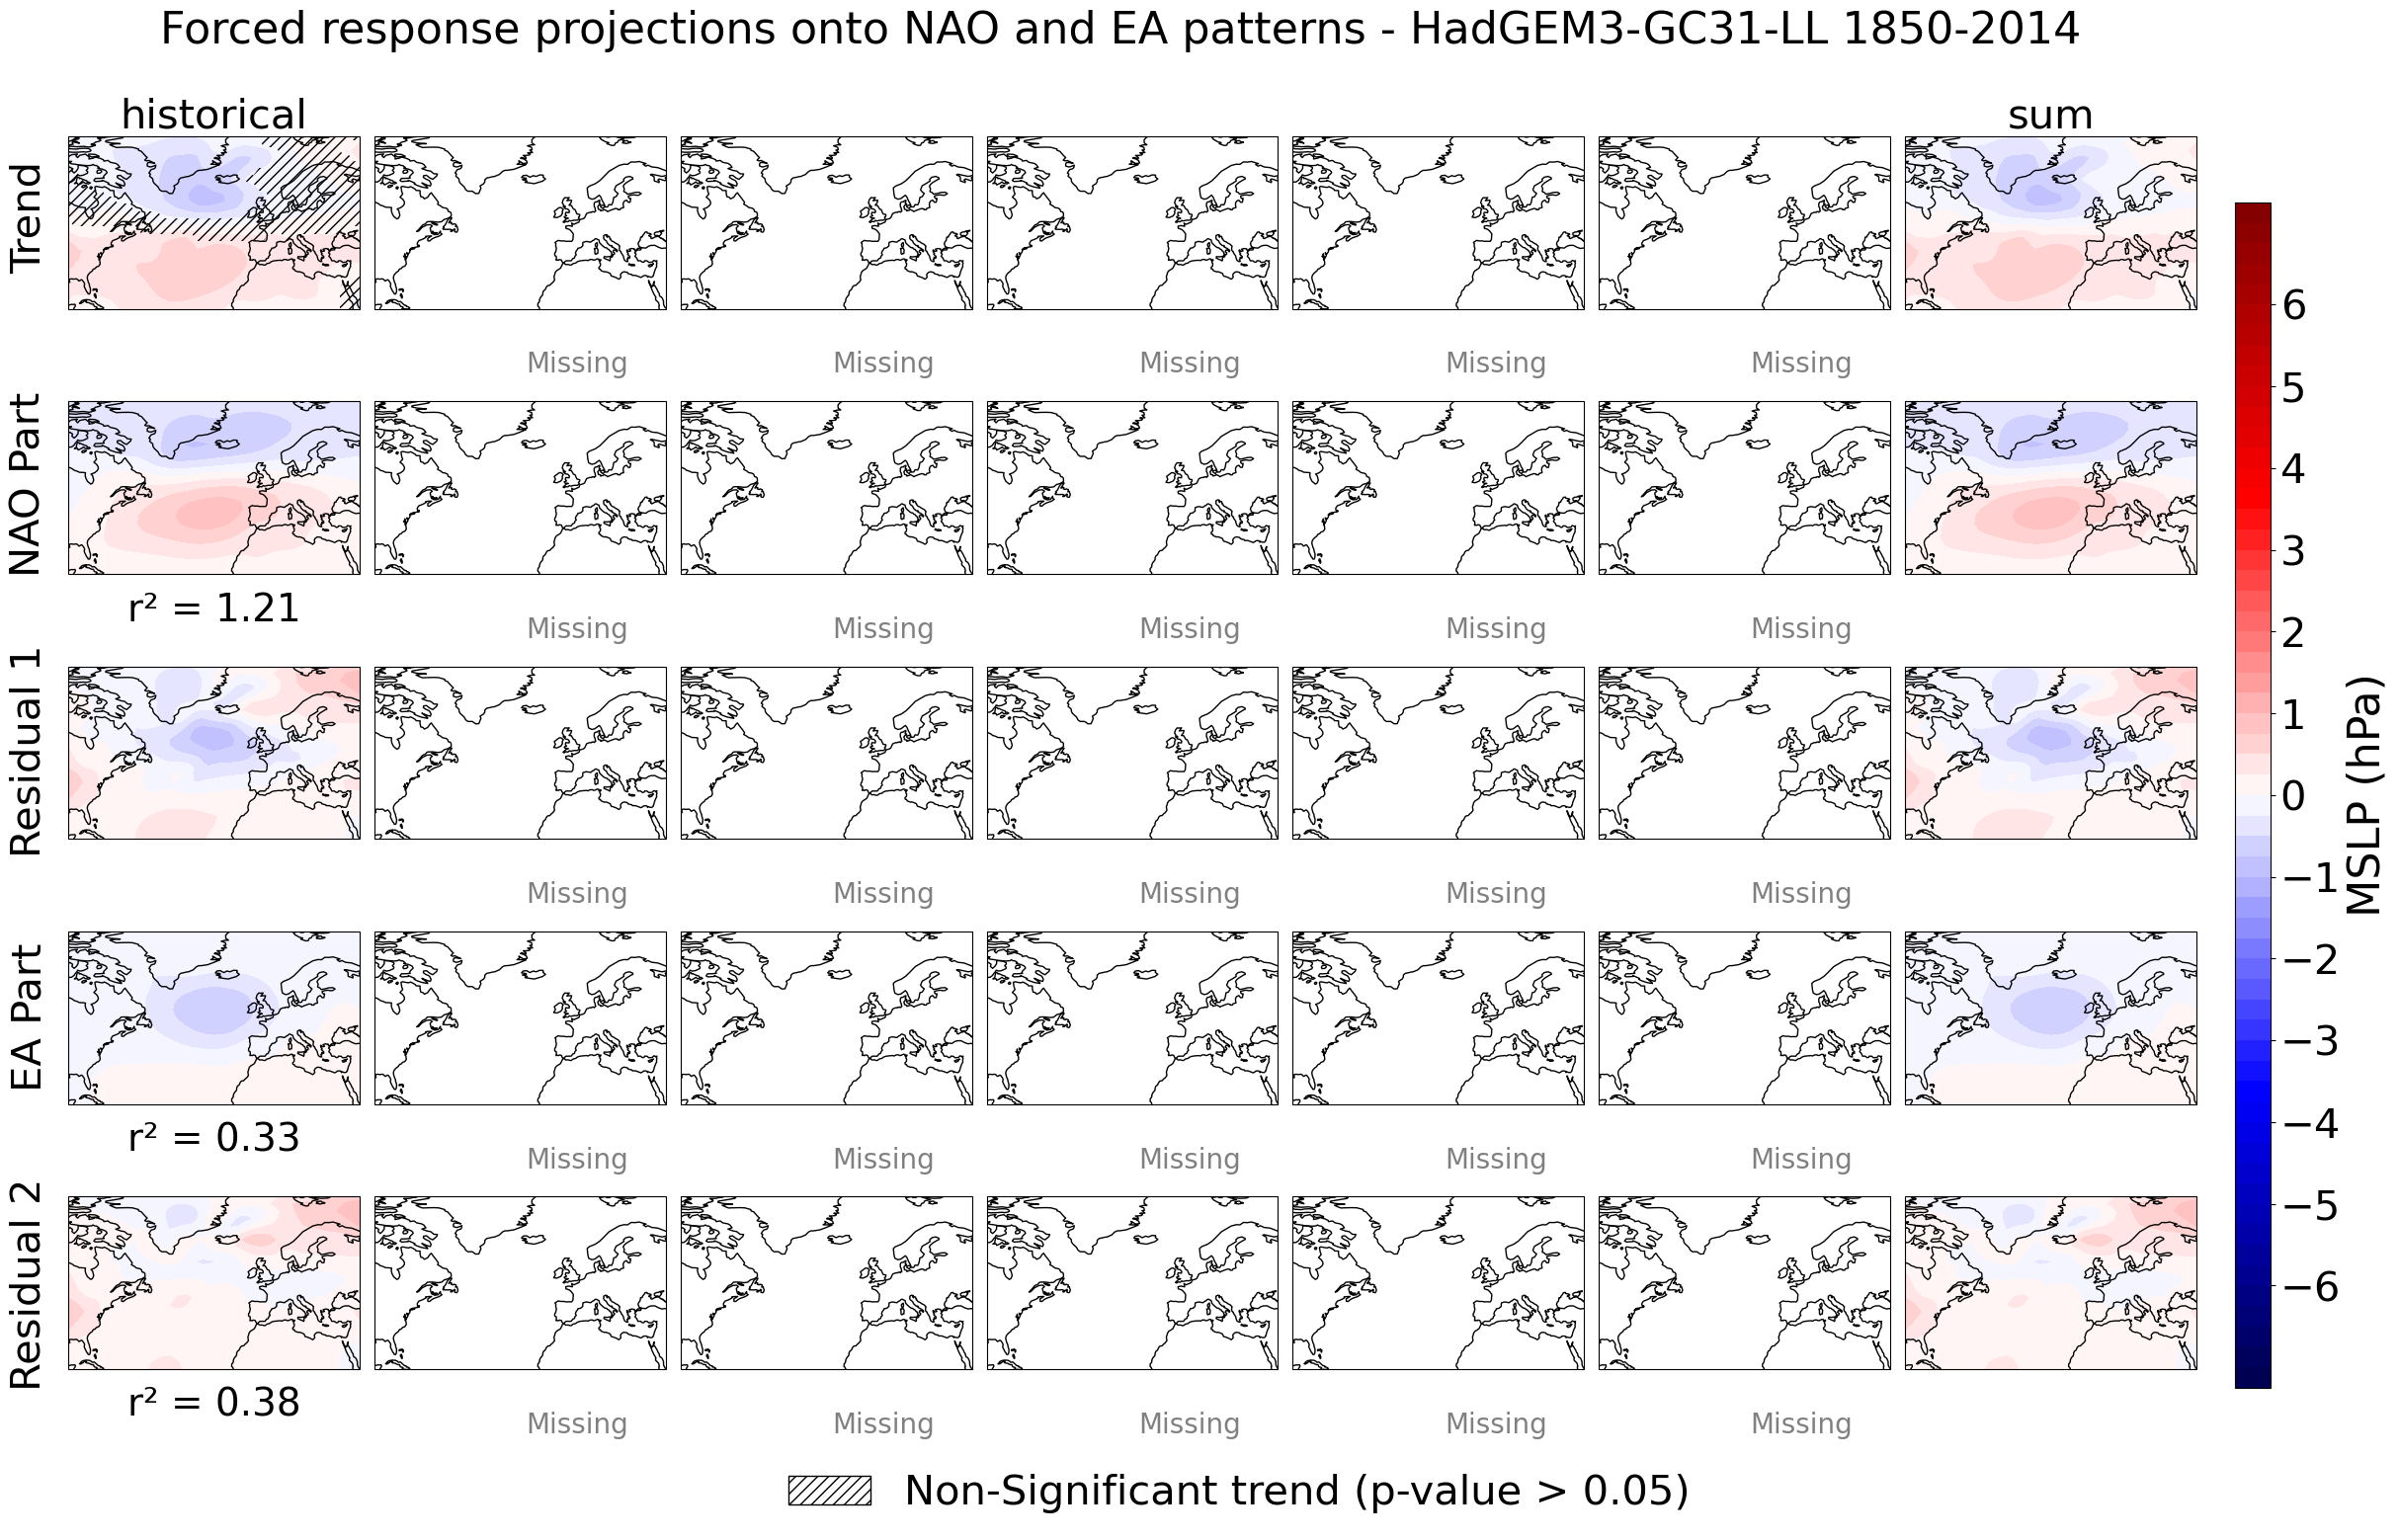

In [30]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(24,15), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

norm_all = mcolors.TwoSlopeNorm(vmin=-7.25, vcenter=0, vmax=7.25)

levels = np.arange(-7.25,7.5,0.25)
# Color normalization - same as prior

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for i, (data_dict, varname) in enumerate(data_layers):
    for j, experiment in enumerate(titles):
        try:
            data = data_dict[experiment]
            contour = ax[i, j].contourf(data['lon'], data['lat'], data[varname], cmap=cmap, norm=norm_all, levels=levels)
            if i == 0 and j<6:
                mask = data['p_value'] > 0.05
                ax[i,j].contourf(data['lon'], data['lat'], mask, levels=[0.5,1], colors='none', hatches=['///'], transform=ccrs.PlateCarree(), alpha=0)
    
            if i == 0:
                ax[i, j].set_title(experiment, fontsize=30)
            
            if i == 1 and j<6:
                r2_NAO = r2_scores[experiment]['NAO']
                #add the r^2 value just below the plots
                ax[i,j].text(0.5, -0.1, f"r² = {r2_NAO:.2f}", transform=ax[i, j].transAxes, ha='center', va='top', fontsize=28)
    
            if i == 3 and j<6:
                r2_EA = r2_scores[experiment]['EA']
                #add the r^2 value just below the plots
                ax[i,j].text(0.5, -0.1, f"r² = {r2_EA:.2f}", transform=ax[i, j].transAxes, ha='center', va='top', fontsize=28)
    
            if i == 4 and j<6:
                r2_res = r2_scores[experiment]['res']
                #add the r^2 value just below the plots
                ax[i,j].text(0.5, -0.1, f"r² = {r2_res:.2f}", transform=ax[i, j].transAxes, ha='center', va='top', fontsize=28)

        except KeyError:
            #If missing experiment data
            ax[i,j].text(0.5, 0.5, 'Missing', ha='center', va='center', fontsize=20, color='gray')
# Add coastlines and formatting
for i in range(5):
    for j in range(7):
        ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i, j].set_xlabel('lon', fontsize=12)
        ax[i, j].set_ylabel('lat', fontsize=12)
        ax[i, j].set_aspect('auto')

# Add colorbar
ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]

cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(contour, cax=cax, orientation='vertical', ticks=ticks)
cbar.set_label('MSLP (hPa)', fontsize=32)
cbar.ax.tick_params(labelsize=30)


# Add overall labels and title
fig.suptitle(f"Forced response projections onto NAO and EA patterns - {model[0]} {period_title}", x=0.45, fontsize=32)
row_labels = ['Trend', 'NAO Part', 'Residual 1', 'EA Part', 'Residual 2']
for i, label in enumerate(row_labels):
    fig.text(-0.01, 0.84 - i*0.18, label, rotation=90, va='center', ha='center', fontsize=30)


# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Non-Significant trend (p-value > 0.05)')

#fig.subplots_adjust(bottom=0.15)  # Add space at the bottom

# Add the legend below the plot
fig.legend(handles=[patch1], loc='lower center', fontsize=30, frameon=False, bbox_to_anchor=(0.5, -0.06))

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/5-row-figs/Forced_response_trend_proj_no_flip{model[0]}_{period_title}.svg', bbox_inches='tight')
plt.show()


#for exp, scores in r2_scores.items():
#    print(f"{exp}: r²_NAO = {scores['NAO']:.4f}, r²_EA = {scores['EA']:.4f}")

In [31]:
#PLOTTING - checking additivity

# Define the forcings
experiments = ['hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']

# Sum all individual forcings
historical_trend_sum = sum(trend_data[experiment] for experiment in experiments)

# Compute the difference
historical_trend_diff = historical_trend_sum - trend_data['historical']

# Set up the figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 6), subplot_kw={'projection': ccrs.PlateCarree()})
titles_additivity = [
    'historical (sum of single forcings)',
    'historical',
    'difference'
]
data_to_plot = [
    historical_trend_sum,
    trend_data['historical'],
    historical_trend_diff
]

minimum = np.min([
    np.min(historical_trend_sum['slope']),
    np.min(trend_data['historical']['slope']),
    np.min(historical_trend_diff['slope'])
])

maximum = np.max([
    np.max(historical_trend_sum['slope']),
    np.max(trend_data['historical']['slope']),
    np.max(historical_trend_diff['slope'])
])

print(minimum,maximum)
norm = mcolors.TwoSlopeNorm(vmin=-5.6, vcenter=0, vmax=5.6)
levels = np.arange(-2,6,0.4)

# Plot
for i in range(3):
    cont = ax[i].contourf(
        data_to_plot[i]['lon'], 
        data_to_plot[i]['lat'], 
        data_to_plot[i]['slope'], 
        cmap=cmap, norm=norm, levels=levels)
    #)
    ax[i].set_title(titles_additivity[i], fontsize = 30)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

cax = fig.add_axes([0.05, -0.1, 0.9, 0.1])
cbar = fig.colorbar(cont, cax=cax, orientation='horizontal', ticks=ticks)
cbar.set_label('MSLP Trend (hPa)', fontsize=26)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=26)
ax[0].set_title('a)', loc='left', fontsize=26)
ax[1].set_title('b)', loc='left', fontsize=26)
ax[2].set_title('c)', loc='left', fontsize=26)


fig.suptitle(f"Comparing the forced responses of the single and all-forcing experiments for {model[0]} ({period_title})", fontsize=30)
plt.tight_layout()
plt.savefig(f'Figures/Transfer_talk/Comparing_historical_to_sum_{model[0]}_{period_title}.png', bbox_inches='tight')

KeyError: 'hist-aer'

-5.270519645000462 4.124283494351493


/tmp/ipykernel_7893/1339089699.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


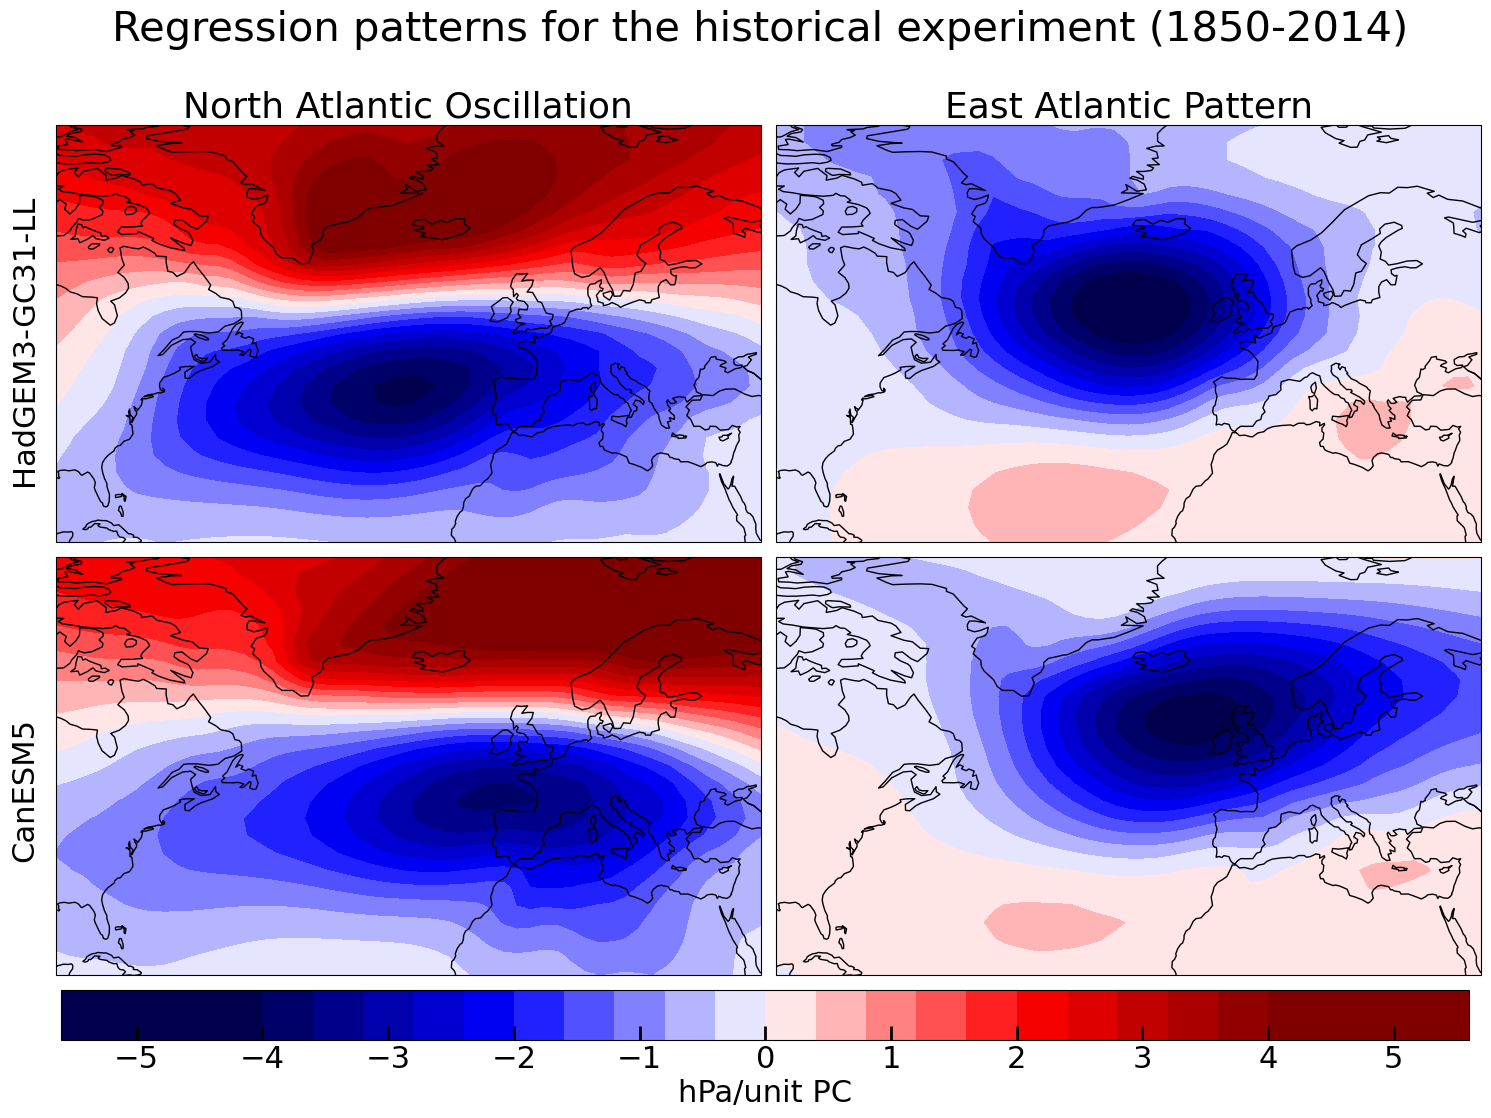

In [14]:
#PLOTTING REGRESSION MAPS - COULD DO DICTIONARY AND MAKE THIS MUCH SMOOTHER BUT... MEH
NAO_pattern_Had = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map_'+period+'.nc')
EA_pattern_Had = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_regression_map_'+period+'.nc')
NAO_pattern_Can = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/CanESM5/psl_mon_historical_CanESM5_DJF_NAO_regression_map_'+period+'.nc')
EA_pattern_Can = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/CanESM5/psl_mon_historical_CanESM5_DJF_EA_regression_map_'+period+'.nc')

min_NAO_Had = np.min(NAO_pattern_Had['regression_NAO_djf'].values)
max_NAO_Had = np.max(NAO_pattern_Had['regression_NAO_djf'].values)
min_EA_Had = np.min(EA_pattern_Had['regression_EA_djf'].values)
max_EA_Had = np.max(EA_pattern_Had['regression_EA_djf'].values)

min_NAO_Can = np.min(NAO_pattern_Can['regression_NAO_djf'].values)
max_NAO_Can = np.max(NAO_pattern_Can['regression_NAO_djf'].values)
min_EA_Can = np.min(EA_pattern_Can['regression_EA_djf'].values)
max_EA_Can = np.max(EA_pattern_Can['regression_EA_djf'].values)

min_pattern = min(min_NAO_Had, min_EA_Had,min_NAO_Can, min_EA_Can)
max_pattern = max(max_NAO_Had, max_EA_Had,max_NAO_Can, max_EA_Can)

lon_NAO_Had = NAO_pattern_Had['lon'].values
lat_NAO_Had = NAO_pattern_Had['lat'].values
lon_EA_Had = EA_pattern_Had['lon'].values
lat_EA_Had = EA_pattern_Had['lat'].values

lon_NAO_Can = NAO_pattern_Can['lon'].values
lat_NAO_Can = NAO_pattern_Can['lat'].values
lon_EA_Can = EA_pattern_Can['lon'].values
lat_EA_Can = EA_pattern_Can['lat'].values

print(min_pattern,max_pattern)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'
norm_pattern = mcolors.TwoSlopeNorm(vmin=-max_pattern, vcenter=0, vmax=max_pattern)
levels = np.arange(-5.6,6,0.4)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('lon')
        ax[i,j].set_ylabel('lat')
        ax[i,j].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
        ax[i,j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i,j].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

contour = ax[0,0].contourf(lon_NAO_Had, lat_NAO_Had, (-1*NAO_pattern_Had['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())
ax[0,1].contourf(lon_EA_Had, lat_EA_Had, EA_pattern_Had['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())
ax[1,0].contourf(lon_NAO_Can, lat_NAO_Can, (-1*NAO_pattern_Can['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())
ax[1,1].contourf(lon_EA_Can, lat_EA_Can, EA_pattern_Can['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())

ticks = [-5,-4,-3,-2,-1,-0,1,2,3,4,5]

cax = fig.add_axes([0.013, -0.05, 0.88, 0.05])
cbar = fig.colorbar(contour, cax=cax, orientation='horizontal', ticks=ticks)
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)
ax[0,0].set_title('North Atlantic Oscillation', fontsize=26)
ax[0,1].set_title('East Atlantic Pattern', fontsize=26)

row_labels = ['HadGEM3-GC31-LL', 'CanESM5']
for i, label in enumerate(row_labels):
    fig.text(-0.01, 0.65 - i*0.45, label, rotation=90, va='center', ha='center', fontsize=22)


# Add overall labels and title
fig.suptitle(f"Regression patterns for the historical experiment ({period_title})",x=0.45, fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/NA_WG_talk/NAO_EA_regression_patterns_Had_Can_{period_title}.svg', bbox_inches='tight')
plt.show()

/tmp/ipykernel_7893/1255993375.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


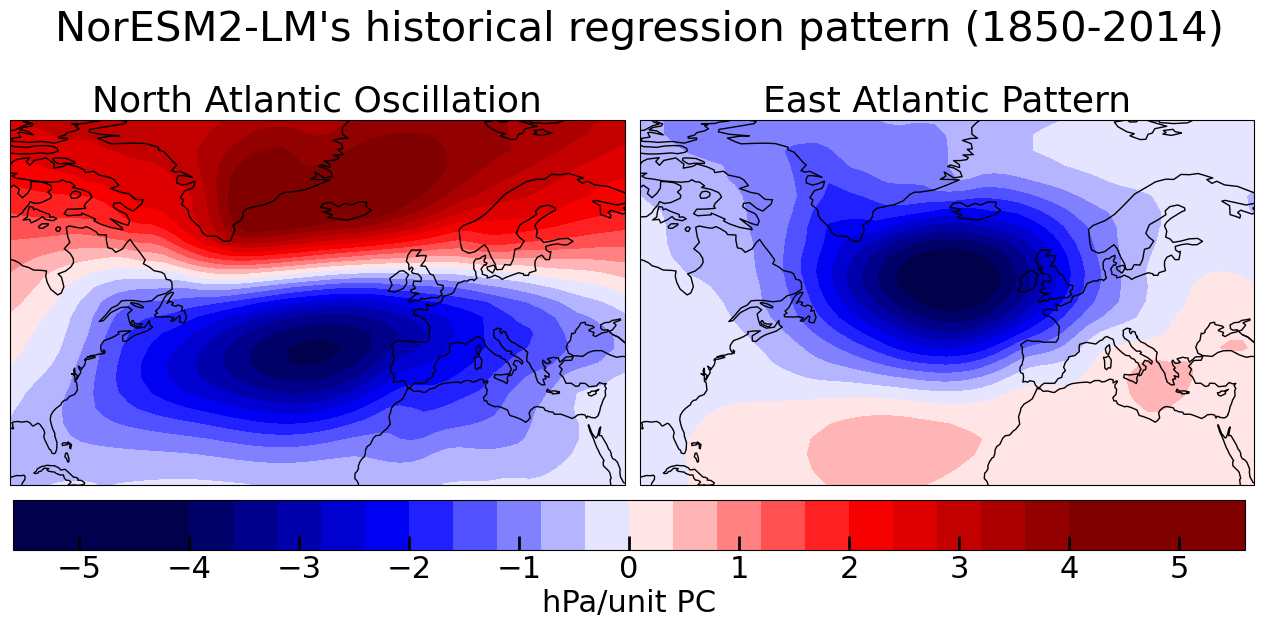

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'
norm_pattern = mcolors.TwoSlopeNorm(vmin=-max_pattern, vcenter=0, vmax=max_pattern)
levels = np.arange(-5.6,6,0.4)

contour = ax[0].contourf(lon_NAO_Had, lat_NAO_Had, (-1*NAO_pattern_Had['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())
ax[1].contourf(lon_EA_Had, lat_EA_Had, EA_pattern_Had['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

ticks = [-5,-4,-3,-2,-1,-0,1,2,3,4,5]

cax = fig.add_axes([0.013, -0.1, 0.88, 0.1])
cbar = fig.colorbar(contour, cax=cax, orientation='horizontal', ticks=ticks)
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)
ax[0].set_title('North Atlantic Oscillation', fontsize=26)
ax[1].set_title('East Atlantic Pattern', fontsize=26)

# Add overall labels and title
fig.suptitle(f"{model[0]}'s historical regression pattern ({period_title})", x=0.46, fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/NA_WG_talk/NAO_EA_regression_patterns_{model[0]}_{period_title}.svg', bbox_inches='tight')
plt.show()

NameError: name 'dummy_cont' is not defined

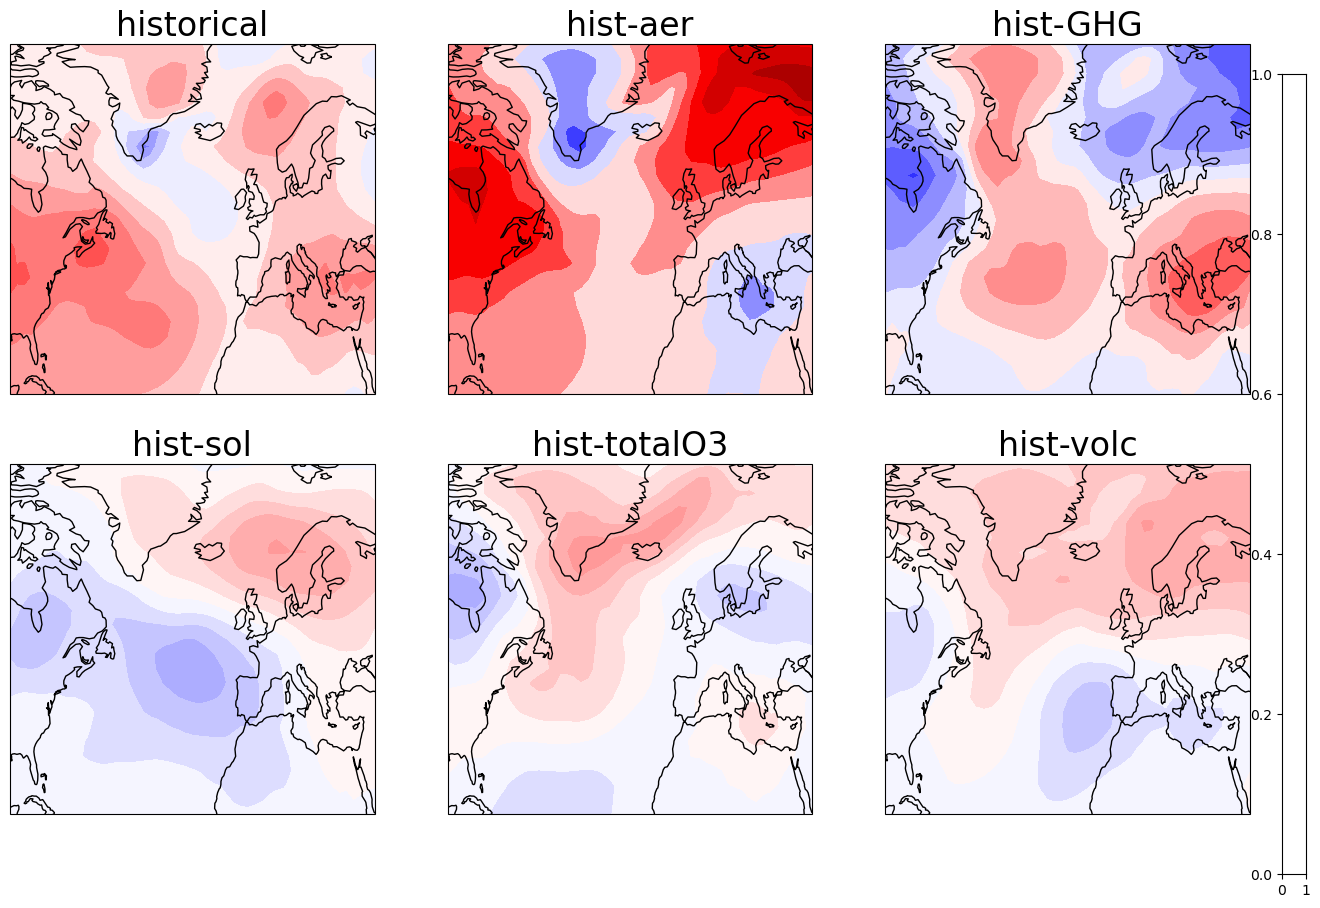

In [16]:
#PLOTTING - 5 row fig, trend, NAO part, residual 1, EA part, residual 2

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'
titles = ['historical','hist-aer','hist-GHG','hist-sol','hist-totalO3','hist-volc']

# Dummy colorbar setup
#max_abs = np.round(max(abs(min_all), abs(max_all)),1)
#levels = np.round(np.linspace(-max_abs, max_abs, 50),1)
#dummy_data = np.array([[min_all, max_all], [min_all, max_all]])
#dummy_cont = ax[0,0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_all)#, levels=levels)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column
for k in range(6):
    if k < 3:
        i = 0
        j = k
    else:
        i = 1
        j = k-3
    data = trend_data[titles[k]]
    mask = data['p_value'] > 0.05
    ax[i,j].contourf(data['lon'], data['lat'], data['slope'], cmap=cmap, norm=norm_all)#, levels=levels)
    #ax[i,j].contourf(data['lon'], data['lat'], mask, levels=[0.5,1], colors='none', hatches=['///'], transform=ccrs.PlateCarree(), alpha=0)

    ax[i,j].set_title(titles[k], fontsize=24)

# Add coastlines and formatting
for i in range(2):
    for j in range(3):
        ax[i,j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i,j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i,j].set_xlabel('lon', fontsize=12)
        ax[i,j].set_ylabel('lat', fontsize=12)
        ax[i,j].set_aspect('auto')

# Add colorbar
cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(dummy_cont, cax=cax)
cbar.set_label('MSLP Trend (hPa)', fontsize=18)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=18)
#cbar.locator = MaxNLocator(nbins=10)
#cbar.update_ticks()

# Add overall labels and title
fig.suptitle(f"Forced response trend DJF {model[0]} {period_title}", fontsize=24)

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/Forced_response_trend_{model[0]}_{period_title}.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_7893/2838351638.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])


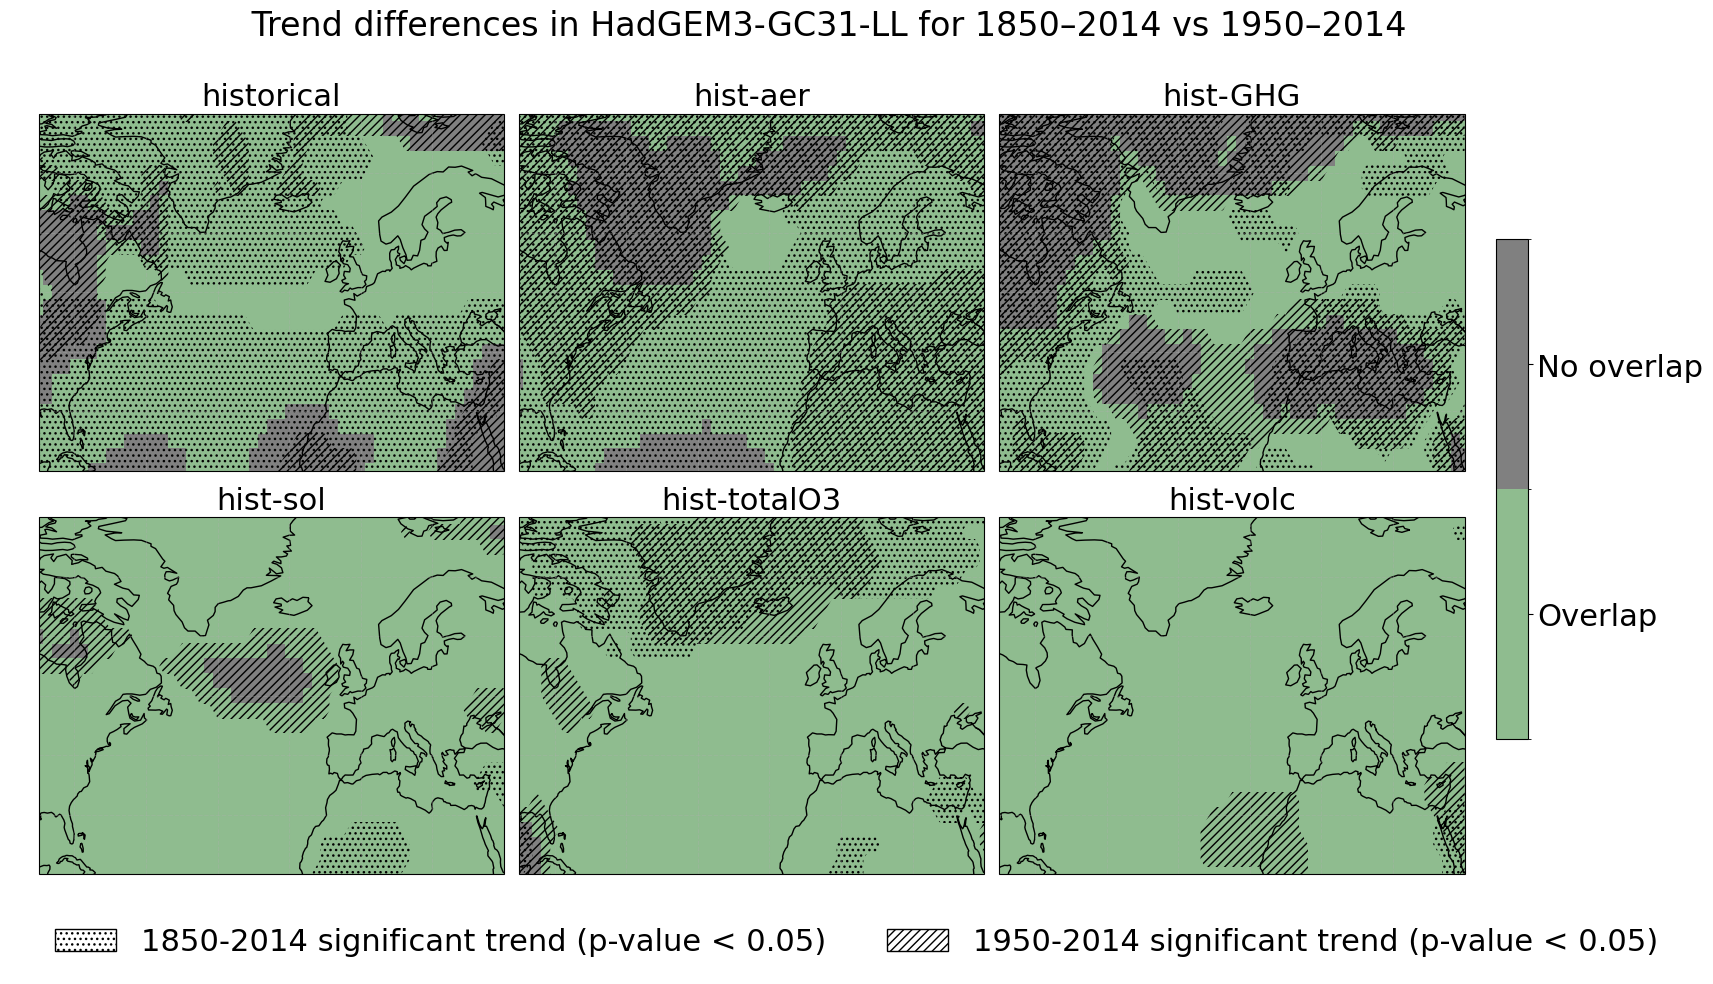

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Custom colors for False (overlap), True (no overlap)
cmap = mcolors.ListedColormap(['darkseagreen', 'grey'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

lat_range = slice(20, 80)
lon_range = slice(-90, 40)

experiment = ['historical','hist-aer','hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
m = 'HadGEM3-GC31-LL'

#basically can give an indes whilts going through each experiment
for i, e in enumerate(experiment):
    ds1 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1850-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1950-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    
    ci_upper1 = ds1['slope_CI_upper']
    ci_upper2 = ds2['slope_CI_upper']
    ci_lower1 = ds1['slope_CI_lower']
    ci_lower2 = ds2['slope_CI_lower']
    
    mask = (ci_upper1 < ci_lower2)|(ci_upper2 < ci_lower1)


    ax = axes[i]

    #creates a mask to find TRUE = no overlap, FALSE = overlap between the confidience intervals of the 2 trend periods
    mask.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

    #creating the stipling/hatching for the significance of indiviual trends
    #basically where the trends are not zero
    #need to get some significance masks
    sig1 = ds1['p_value'] < 0.05
    sig2 = ds2['p_value'] < 0.05

    # /// diagonal hatching, xxx cross hatching
    ax.contourf(ds1['lon'], ds1['lat'], sig1, levels=[0.5,1], colors='none', hatches=['...'], transform=ccrs.PlateCarree(), alpha=0)
    ax.contourf(ds2['lon'], ds2['lat'], sig2, levels=[0.5,1], colors='none', hatches=['////'], transform=ccrs.PlateCarree(), alpha=0)
    
    ax.coastlines()
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(e, fontsize=22)
    ax.set_extent([lon_range.start, lon_range.stop, lat_range.start, lat_range.stop], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', alpha=0.3)
    ax.set_aspect('auto')  
    
# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='...', label='1850-2014 significant trend (p-value < 0.05)')
patch2 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='////', label='1950-2014 significant trend (p-value < 0.05)')

fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2, fontsize=22, frameon=False)

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Overlap', 'No overlap'], fontsize=22)
    
plt.suptitle(" Trend differences in " + m + " for 1850–2014 vs 1950–2014", fontsize=24)
plt.savefig(f'Figures/Trend_differences_significance_{m}.png', bbox_inches='tight')
plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])
plt.show()